## libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
# --- 1. SETUP AND DATA PREPARATION ---

print("Setting up NLTK...")
# Download necessary NLTK data packages
# Download all necessary NLTK data 

nltk.download('punkt')
nltk.download('punkt_tab') 
nltk.download('stopwords')
nltk.download('wordnet')
print("NLTK setup complete.")

Setting up NLTK...
NLTK setup complete.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# load the dataset 
df = pd.read_excel('ai_dev_assignment_tickets_complex_1000.xls')

In [16]:
df.head()

,ticket_id,ticket_text,issue_type,urgency_level,product,cleaned_text
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2,payment issue smartwatch v underbilled order
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300,ordered soundwave got ecobreeze ac instead ord...
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam,facing installation issue photosnap cam setup ...
5,6,Can you tell me more about the PhotoSnap Cam w...,General Inquiry,Medium,PhotoSnap Cam,tell photosnap cam warranty also available red
6,7,is malfunction. It stopped working after just...,Product Defect,Low,EcoBreeze AC,malfunction stopped working day


In [6]:
# Preprocessing Function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [7]:
def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(w) for w in tokens if w not in stop_words])

In [8]:
# Clean and Prepare DataFrame
df.dropna(subset=['issue_type', 'urgency_level', 'product', 'ticket_text'], inplace=True)
df['cleaned_text'] = df['ticket_text'].apply(preprocess_text)
print("Data preparation complete.")
print(df[['ticket_text', 'cleaned_text', 'issue_type', 'urgency_level']].head())

Data preparation complete.
                                         ticket_text  \
0  Payment issue for my SmartWatch V2. I was unde...   
2  I ordered SoundWave 300 but got EcoBreeze AC i...   
3  Facing installation issue with PhotoSnap Cam. ...   
5  Can you tell me more about the PhotoSnap Cam w...   
6   is malfunction. It stopped working after just...   

                                        cleaned_text          issue_type  \
0       payment issue smartwatch v underbilled order     Billing Problem   
2  ordered soundwave got ecobreeze ac instead ord...          Wrong Item   
3  facing installation issue photosnap cam setup ...  Installation Issue   
5     tell photosnap cam warranty also available red     General Inquiry   
6                    malfunction stopped working day      Product Defect   

  urgency_level  
0        Medium  
2        Medium  
3           Low  
5        Medium  
6           Low  


In [9]:
# Step 3: Feature Engineering
tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_features = X_tfidf_df.copy()
df_features['ticket_length'] = df['cleaned_text'].apply(len).values
df_features['sentiment'] = df['cleaned_text'].apply(lambda text: TextBlob(text).sentiment.polarity).values

X_combined = df_features
print(f"Feature engineering complete. Shape of feature matrix: {X_combined.shape}")

Feature engineering complete. Shape of feature matrix: (826, 551)


In [10]:
# Step 4: Multi-Task Model Training & Evaluation
models_to_evaluate = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Linear SVM (SVC)": LinearSVC(random_state=42, dual=True),
    "Random Forest": RandomForestClassifier(random_state=42)
}

In [11]:
def evaluate_task(X, y, task_name):
    print(f"--- Evaluating Models for {task_name} ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    for name, model in models_to_evaluate.items():
        print(f"\n--- Model: {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred))
        
        # Plotting Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
        plt.title(f'Confusion Matrix for {name} on {task_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print("-" * 50)

--- Evaluating Models for Issue Type ---

--- Model: Logistic Regression ---
Accuracy: 1.0000
                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        27
   Billing Problem       1.00      1.00      1.00        26
   General Inquiry       1.00      1.00      1.00        25
Installation Issue       1.00      1.00      1.00        26
     Late Delivery       1.00      1.00      1.00        19
    Product Defect       1.00      1.00      1.00        22
        Wrong Item       1.00      1.00      1.00        21

          accuracy                           1.00       166
         macro avg       1.00      1.00      1.00       166
      weighted avg       1.00      1.00      1.00       166



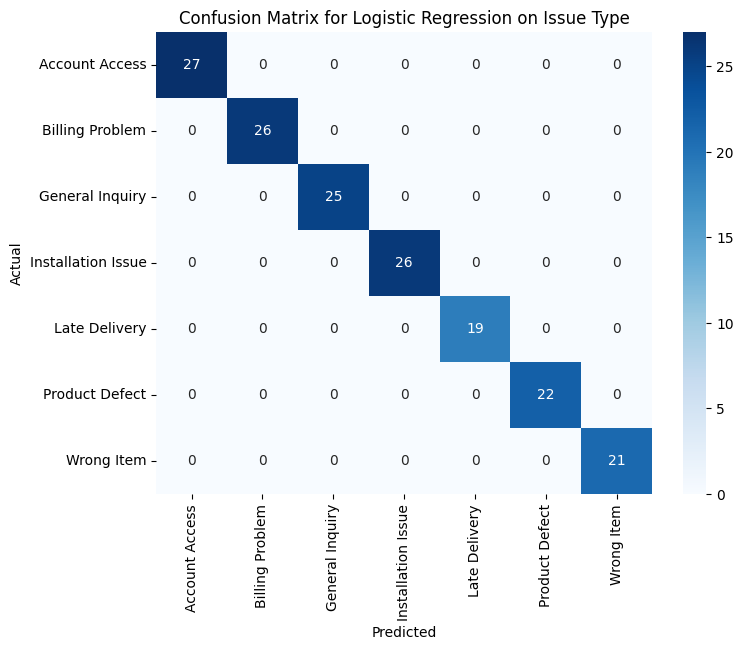

--------------------------------------------------

--- Model: Linear SVM (SVC) ---
Accuracy: 1.0000
                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        27
   Billing Problem       1.00      1.00      1.00        26
   General Inquiry       1.00      1.00      1.00        25
Installation Issue       1.00      1.00      1.00        26
     Late Delivery       1.00      1.00      1.00        19
    Product Defect       1.00      1.00      1.00        22
        Wrong Item       1.00      1.00      1.00        21

          accuracy                           1.00       166
         macro avg       1.00      1.00      1.00       166
      weighted avg       1.00      1.00      1.00       166



/Users/pradhyumnyadav/Desktop/vijayi /venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


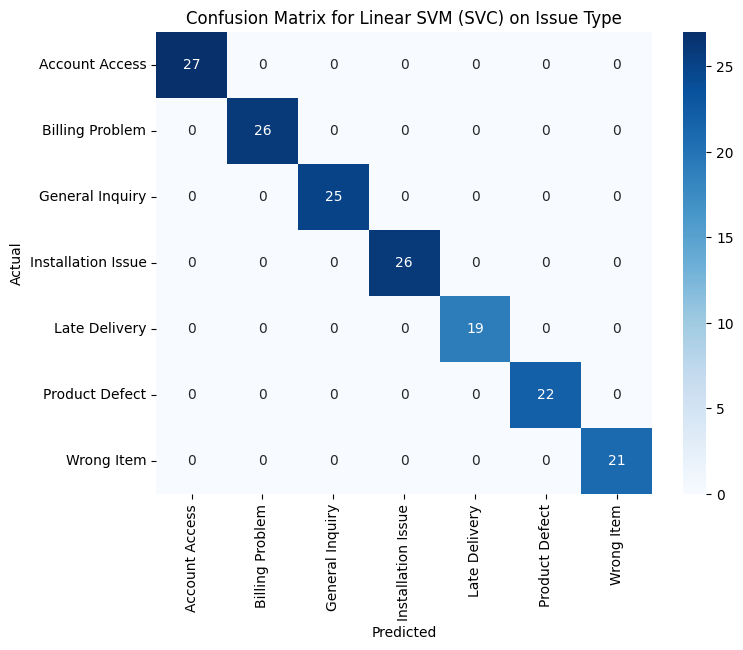

--------------------------------------------------

--- Model: Random Forest ---
Accuracy: 1.0000
                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        27
   Billing Problem       1.00      1.00      1.00        26
   General Inquiry       1.00      1.00      1.00        25
Installation Issue       1.00      1.00      1.00        26
     Late Delivery       1.00      1.00      1.00        19
    Product Defect       1.00      1.00      1.00        22
        Wrong Item       1.00      1.00      1.00        21

          accuracy                           1.00       166
         macro avg       1.00      1.00      1.00       166
      weighted avg       1.00      1.00      1.00       166



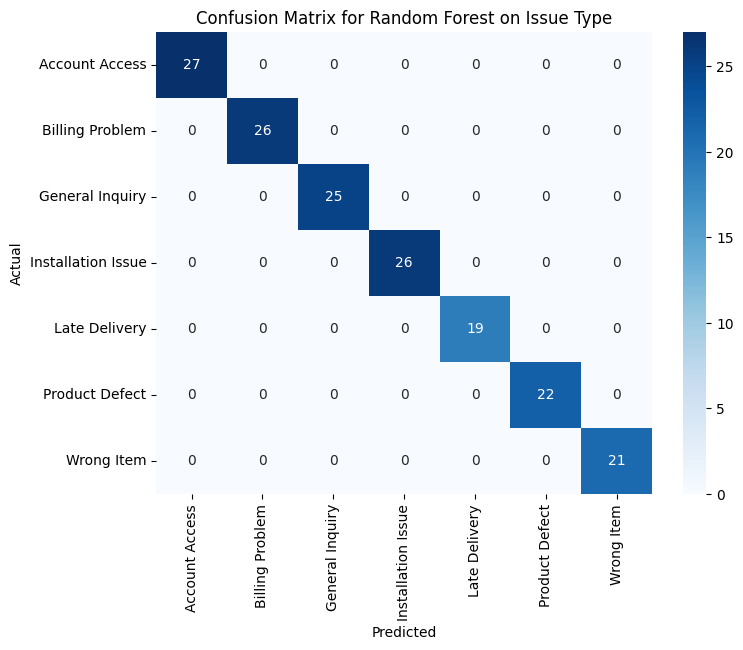

--------------------------------------------------


In [13]:
# 4.1 Evaluation for 'Issue Type' Classification
y_issue = df['issue_type']
evaluate_task(X_combined, y_issue, "Issue Type")



--- Evaluating Models for Urgency Level ---

--- Model: Logistic Regression ---
Accuracy: 0.3434
              precision    recall  f1-score   support

        High       0.35      0.40      0.37        58
         Low       0.33      0.27      0.30        52
      Medium       0.34      0.36      0.35        56

    accuracy                           0.34       166
   macro avg       0.34      0.34      0.34       166
weighted avg       0.34      0.34      0.34       166



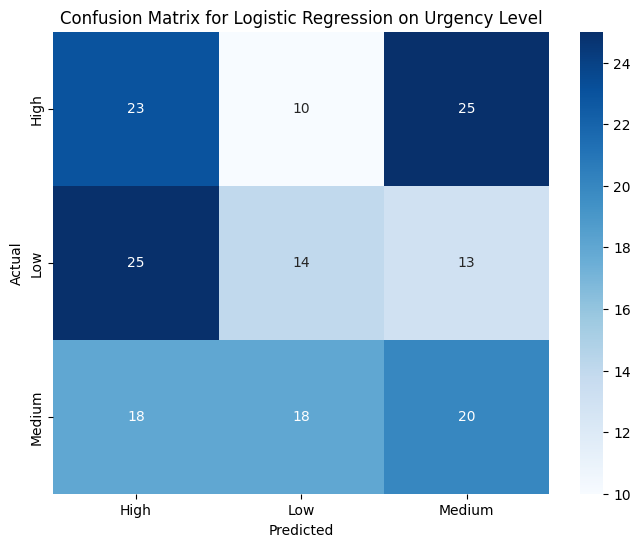

--------------------------------------------------

--- Model: Linear SVM (SVC) ---
Accuracy: 0.3193
              precision    recall  f1-score   support

        High       0.40      0.21      0.27        58
         Low       0.29      0.37      0.32        52
      Medium       0.31      0.39      0.35        56

    accuracy                           0.32       166
   macro avg       0.33      0.32      0.31       166
weighted avg       0.34      0.32      0.31       166



/Users/pradhyumnyadav/Desktop/vijayi /venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


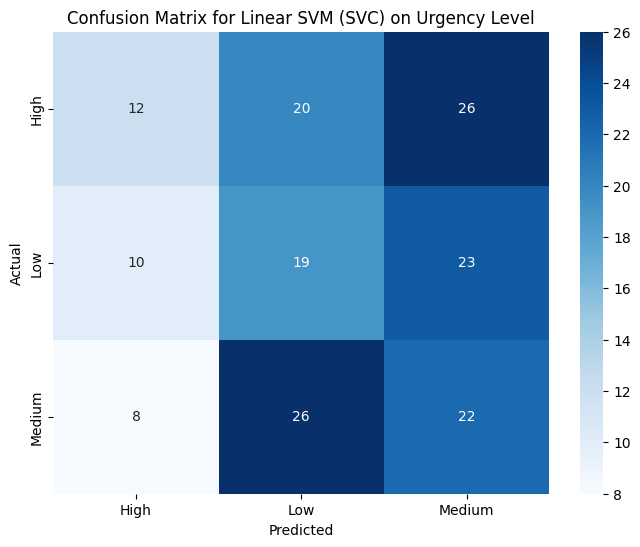

--------------------------------------------------

--- Model: Random Forest ---
Accuracy: 0.3072
              precision    recall  f1-score   support

        High       0.41      0.38      0.39        58
         Low       0.25      0.27      0.26        52
      Medium       0.27      0.27      0.27        56

    accuracy                           0.31       166
   macro avg       0.31      0.31      0.31       166
weighted avg       0.31      0.31      0.31       166



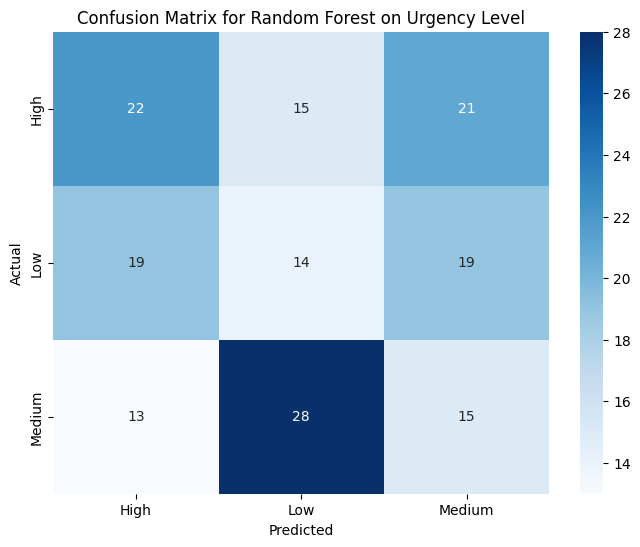

--------------------------------------------------


In [14]:
# 4.2 Evaluation for 'Urgency Level' Classification
y_urgency = df['urgency_level']
evaluate_task(X_combined, y_urgency, "Urgency Level")

In [15]:
# Step 5: Final Model Training and Saving
# Train final Issue Type classifier on all data
final_issue_classifier = RandomForestClassifier(random_state=42)
final_issue_classifier.fit(X_combined, y_issue)
joblib.dump(final_issue_classifier, 'issue_classifier.pkl')

# Train final Urgency Level classifier on all data
final_urgency_classifier = LinearSVC(random_state=42, dual=True)
final_urgency_classifier.fit(X_combined, y_urgency)
joblib.dump(final_urgency_classifier, 'urgency_classifier.pkl')

# Save the vectorizer and product list
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(df['product'].unique(), 'product_list.pkl')

print("Final models and vectorizer saved successfully.")

Final models and vectorizer saved successfully.


/Users/pradhyumnyadav/Desktop/vijayi /venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
